## Fera Formidável 4.3
### Derrube pra fora
#### Rômulo 24024

### Enunciado:
**Objetivo:** implemente o regularizador dropout na rede neural feita em Python puro.

**Comentário:** algumas tarefas vão apresentar palavras e conceitos que ainda não
vimos em sala. Parte do desafio é justamente se informar sobre estes conceitos.

**Comentário 2:** observe que o enunciado diz claramente que é para realizar a tarefa
na rede neural feita em Python puro nos vídeos da disciplina. Se você está usando o
PyTorch, numpy, tensorflow, keras, lightning ou qualquer outra biblioteca pronta,
você está no caminho errado!


### Introdução:
**Dropout** é uma técnica de regularização usada em redes neurais para reduzir o overfitting. Durante o treinamento, ela desativa aleatoriamente uma fração dos neurônios em cada camada oculta, forçando a rede a não depender excessivamente de neurônios específicos e a aprender representações mais robustas. Isso melhora a capacidade de generalização do modelo.

Implementarei o regularizador dropout na fase de forward pass. Para isso, adicionarei um parâmetro chamado `dropout` no método `__call__` da MLP, que representa a taxa de dropout dos neurônios das camadas ocultas. Quando a taxa for nula (padrão), nenhum neurônio será desligado; quando for um, todos os neurônios das camadas ocultas serão desligados. O método `__call__` da MLP propaga o parâmetro para as camadas, que por sua vez propagam para os neurônios. O dropout é aplicado apenas nas camadas ocultas, nunca na camada de entrada ou saída. Cada neurônio sorteia um valor aleatório; se for menor que a taxa de dropout, o neurônio é desligado (retorna zero), caso contrário, permanece ativo. O dropout deve ser aplicado somente durante o treinamento do modelo; na previsão, pode prejudicar a precisão, pois pode desligar neurônios importantes.

#### Imports necessários:

In [1]:
import pandas as pd
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

dados = pd.read_csv('http://gist.githubusercontent.com/slopp/ce3b90b9168f2f921784de84fa445651/raw/4ecf3041f0ed4913e7c230758733948bc561f434/penguins.csv')

Classes em Python puro obtidas das aulas:
Foi adicionado um novo método na MLP chamado dropout, que recebe um parâmetro `dropout`, equivalente à taxa de dropout. Ele atualiza o atributo `status` de cada neurônio nas camadas ocultas. Se o neurônio for desligado, retorna zero como saída, sem afetar seus parâmetros de peso.

In [2]:
class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"
    
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad
            
        resultado.propagar = propagar_adicao
        
        return resultado
    
    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data # grad_filho * derivada filho em relação a mãe
            outro_valor.grad += resultado.grad * self.data
            
        resultado.propagar = propagar_multiplicacao
        
        return resultado
    
    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = np.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_exp():
            self.grad += resultado.grad * data 
        
        resultado.propagar = propagar_exp
        
        return resultado
    
    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))
        
        resultado.propagar = propagar_pow
        
        return resultado
    
    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)
    
    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1
    
    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)
    
    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor
    
    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor
    
    def sig(self):
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        e_neg = (-self).exp()
        return Valor(1) / (Valor(1) + e_neg)
    
    def propagar(self):
        pass
    
    def propagar_tudo(self):
        
        self.grad = 1
        
        ordem_topologica = []
        
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        
        for vertice in reversed(ordem_topologica):
            vertice.propagar()
            
class Neuronio:
    def __init__(self, num_dados_entrada):
        self.status = 1
        self.vies = Valor(random.uniform(-1, 1))
        
        self.pesos = []
        for i in range(num_dados_entrada):
            self.pesos.append(Valor(random.uniform(-1, 1)))
            
    def __call__(self, x):
        
        assert len(x) == len(self.pesos)
        
        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno
            
        soma += self.vies  

        if self.status == 0: # Se essa probabilidade sorteada for menor que a taxa de dropout o neurônio será desligado
            dado_de_saida = Valor(0) 
        else:
            dado_de_saida = soma.sig()

        return dado_de_saida       
    
    def dropout(self,dropout):
        p = random.uniform(0,1)
        if p < dropout:
            self.status = 0
    
    def dropout_clear(self):
        self.status = 1
    
    def parametros(self):
        return self.pesos + [self.vies]
    
class Camada:
    def __init__(self, num_neuronios, num_dados_entrada):
        neuronios = []
        
        for _ in range(num_neuronios):
            neuronio = Neuronio(num_dados_entrada)
            neuronios.append(neuronio)
            
        self.neuronios = neuronios     
        
    def __call__(self, x):
        dados_de_saida = []
        
        for neuronio in self.neuronios:
            informacao = neuronio(x)
            dados_de_saida.append(informacao)
            
        if len(dados_de_saida) == 1:
            return dados_de_saida[0]
        else:        
            return dados_de_saida  

    def dropout(self, dropout):
        for neuronio in self.neuronios:
            neuronio.dropout(dropout)
    
    def dropout_clear(self):
        for neuronio in self.neuronios:
            neuronio.dropout_clear()
    
    def parametros(self):
        params = []
        
        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio)
        
        return params
    
class MLP:
    def __init__(self, num_dados_entrada, num_neuronios_por_camada):
        
        percurso = [num_dados_entrada] + num_neuronios_por_camada
        
        camadas = []
        
        for i in range(len(num_neuronios_por_camada)):
            camada = Camada(num_neuronios_por_camada[i], percurso[i])
            camadas.append(camada)
            
        self.camadas = camadas
        
    def __call__(self, x):
        for camada in self.camadas:
            x = camada(x)
        return x

    def dropout(self, dropout: float = 0):
        if dropout != 0:
            for i, camada in enumerate(self.camadas):
                if i != 0 and i != len(self.camadas) - 1:
                    camada.dropout(dropout)
    
    def dropout_clear(self):
        for camada in self.camadas:
            camada.dropout_clear()

    def parametros(self):
        params = []
        
        for camada in self.camadas:
            parametros_camada = camada.parametros()
            params.extend(parametros_camada)
            
        return params

#### Tratando os dados:
Selecionaremos as seguintes features:
- Comprimento do bico
- Comprimento da nadadeira
- Massa corporal
- Ano de análise

Após isso, faremos a normalização e criaremos o modelo MLP.

Fazendo o split de treino e validação:

In [9]:
indices_teste = random.sample(range(len(dados)), k=int(len(dados)/5))
dados_teste = dados.iloc[indices_teste].dropna()
dados_treino = dados.drop(indices_teste).dropna()

#### Tratando os dados:
Selecionaremos as seguintes features:
- Comprimento do bico
- Comprimento da nadadeira
- Massa corporal
- Ano de análise

Após isso, faremos a normalização e criaremos o modelo MLP.

In [10]:
x = ['bill_length_mm', 'flipper_length_mm','body_mass_g','year']
y = ['bill_depth_mm']

x_treino = dados_treino.loc[:, x]
y_treino = dados_treino.loc[:, y]

x_teste = dados_teste.loc[:, x]
y_teste = dados_teste.loc[:, y]

x_scaler = StandardScaler()
x_scaler.fit(x_treino)

y_scaler = StandardScaler()
y_scaler.fit(y_treino)

x_treino = x_scaler.transform(x_treino)
y_treino = y_scaler.transform(y_treino)

x_teste = x_scaler.transform(x_teste)
y_teste = y_scaler.transform(y_teste)

x = dados.loc[:,x].values
y_true = dados.loc[:,y].values

# Arquitetura MLP:
NUM_DADOS_DE_ENTRADA = 4
NUM_DADOS_DE_SAIDA = 1    
CAMADAS_OCULTAS = [5, 6, 3]  

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]

minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede)

Treino sem dropout:
Um modelo com os mesmos hiperparâmetros, porém com taxa de dropout nula, ou seja, nenhum neurônio será desligado.

In [11]:
minha_mlp_sem_dropout = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede)
NUM_EPOCAS = 10
TAXA_DE_APRENDIZADO = 0.5
checkpoint = [-1,float('inf')]
losses_ = []

for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred = []
    for exemplo in x_treino:
        previsao = minha_mlp_sem_dropout(exemplo)
        y_pred.append(previsao)
    # loss
    erros = []
    for yt, yp in zip(y_treino, y_pred):
        residuo = yp - yt
        erro_quadratico = residuo ** 2
        erros.append(erro_quadratico)        
    loss = sum(erros)/len(erros)
    if loss.data < checkpoint[1]:
        checkpoint = [epoca, loss.data]
        for p in minha_mlp.parametros():
            checkpoint.append(p)
    # zero grad
    for p in minha_mlp_sem_dropout.parametros():
        p.grad = 0
    # backpropagation
    loss.propagar_tudo()
    # atualiza parâmetros
    for p in minha_mlp_sem_dropout.parametros():
        p.data = p.data - p.grad * TAXA_DE_APRENDIZADO
    # mostra resultado (opcional)
    losses_.append(loss)
    print(epoca, loss)

0 Valor(data=[1.23289239])
1 Valor(data=[1.18226138])
2 Valor(data=[1.14438498])
3 Valor(data=[1.11635906])
4 Valor(data=[1.09550679])
5 Valor(data=[1.07977327])
6 Valor(data=[1.06769378])
7 Valor(data=[1.05825108])
8 Valor(data=[1.05074071])
9 Valor(data=[1.04467065])


Treinando com estratégia de dropout:
Aqui o parâmetro será 0.5, portanto, para o neurônio ser mantido, deve ser sorteado um valor maior ou igual a 0.5.

In [12]:
NUM_EPOCAS = 10
TAXA_DE_APRENDIZADO = 0.5
losses = []
for epoca in range(NUM_EPOCAS):
    minha_mlp.dropout(0.5)
    # forward pass
    y_pred = []
    for exemplo in x_treino:
        previsao = minha_mlp(exemplo)
        y_pred.append(previsao)    
    # loss
    erros = []
    for yt, yp in zip(y_treino, y_pred):
        residuo = yp - yt
        erro_quadratico = residuo ** 2
        erros.append(erro_quadratico)        
    loss = sum(erros)/len(erros)
    # zero grad
    for p in minha_mlp.parametros():
        p.grad = 0
    # backpropagation
    loss.propagar_tudo()
    # atualiza parâmetros
    for p in minha_mlp.parametros():
        p.data = p.data - p.grad * TAXA_DE_APRENDIZADO
    minha_mlp.dropout_clear()
    # mostra resultado (opcional)
    losses.append(loss)
    print(epoca, y_pred)

0 [Valor(data=0.7114614377594556), Valor(data=0.7111110822416371), Valor(data=0.7107994049176999), Valor(data=0.7113212959012064), Valor(data=0.7119592101485551), Valor(data=0.7100510774026589), Valor(data=0.7110000802548985), Valor(data=0.71237735302568), Valor(data=0.7117155855666923), Valor(data=0.7101730978199097), Valor(data=0.7107197713420327), Valor(data=0.7117309021681271), Valor(data=0.711629214803107), Valor(data=0.7117733528857096), Valor(data=0.7117175700233049), Valor(data=0.7120193797889511), Valor(data=0.7106452000977885), Valor(data=0.7098776980289888), Valor(data=0.7114362344113231), Valor(data=0.7114931692632037), Valor(data=0.710803358839023), Valor(data=0.7102059893699931), Valor(data=0.7110505996496639), Valor(data=0.7105524370094425), Valor(data=0.711065479175784), Valor(data=0.7112519865055957), Valor(data=0.7104386813265325), Valor(data=0.7111487644078347), Valor(data=0.7124274507565622), Valor(data=0.7111268920811006), Valor(data=0.7109109971238251), Valor(data

Vamos então plotar a curva de perda do modelo com dropout e sem dropout e compará-los:

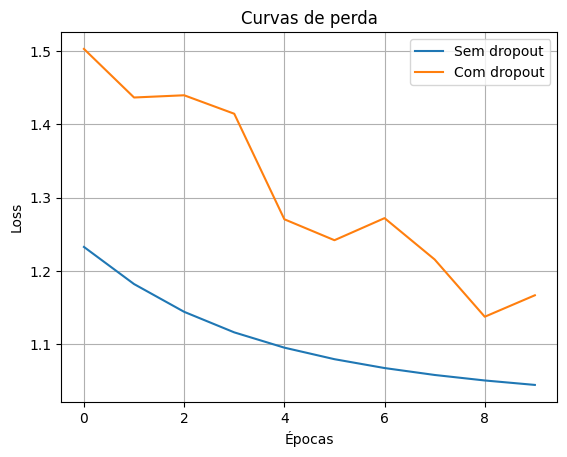

In [13]:
plt.plot(range(NUM_EPOCAS), [loss.data for loss in losses_])
plt.plot(range(NUM_EPOCAS), [loss.data for loss in losses])
plt.title("Curvas de perda")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend(['Sem dropout', 'Com dropout'])
plt.grid()
plt.show()

Podemos perceber uma diferença na forma das curvas: com dropout, nem sempre o treinamento seguinte terá menor perda, pois um neurônio com maiores pesos pode ser desligado.

Fazendo as predições com dados de teste:

In [16]:
# forward pass
y_pred = []
for exemplo in x_teste:
    previsao = minha_mlp_sem_dropout(exemplo)
    y_pred.append(previsao)    
# loss
erros = []
for yt, yp in zip(y_treino, y_pred):
    residuo = yp - yt
    erro_quadratico = residuo ** 2
    erros.append(erro_quadratico)        
loss = sum(erros)/len(erros)

# mostra resultado (opcional)
loss_teste = loss.data
print(loss)

# forward pass
y_pred = []
for exemplo in x_teste:
    previsao = minha_mlp(exemplo)
    y_pred.append(previsao)    
# loss
erros = []
for yt, yp in zip(y_treino, y_pred):
    residuo = yp - yt
    erro_quadratico = residuo ** 2
    erros.append(erro_quadratico)        
loss = sum(erros)/len(erros)

# mostra resultado (opcional)
loss_teste_dropout = loss.data
print(loss)

Valor(data=[0.57732329])
Valor(data=[0.48253577])


C:\Users\romulo24024\AppData\Local\Temp\ipykernel_37952\4289905207.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.bar(['Sem Dropout', 'Com Dropout'], [float(loss_teste), float(loss_teste_dropout)], color='b', alpha=0.7, edgecolor='black')


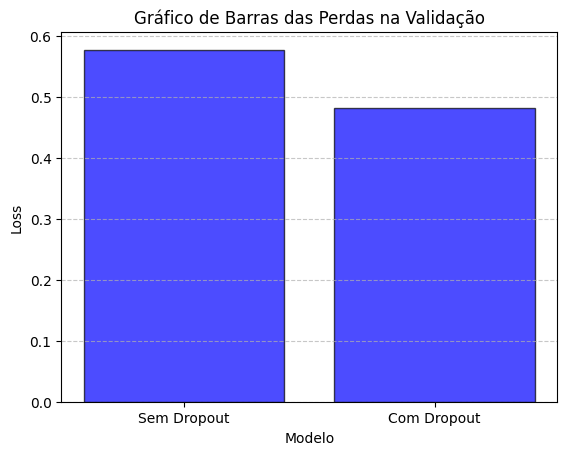

In [19]:
plt.bar(['Sem Dropout', 'Com Dropout'], [float(loss_teste), float(loss_teste_dropout)], color='b', alpha=0.7, edgecolor='black')
plt.title('Gráfico de Barras das Perdas na Validação')
plt.xlabel('Modelo')
plt.ylabel('Loss')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Esta plotagem é mais informativa, não traz uma informação de que o modelo de dropout tem perda menor que um sem dropout, a menos que ajude a treinar padrões complexos ou ajude a prevenir overfitting.

#### Conclusão:
Conseguimos analisar algumas características do dropout e conferimos que o implementamos corretamente num código de python puro, a partir disto conseguimos aprender mais sobre seu funcionamento. Seria interessante também, futuramente, analisar a capacidade do dropout evitar overfinting, ou como ele pode ajudar um modelo a compreender padrões mais complexos.

### Referências

- Dropout Regularization in Deep Learning
  Disponível em: <https://www.geeksforgeeks.org/dropout-regularization-in-deep-learning/>
- Classes da MLP em Python puro
  Obtidos em: ATP-303 NN 4.2 - Notebook MLP.ipynb